# NASDAQ-100 Predictability Using Machine Learning  
### CS 171 — Final Project  
### By: Yug More

In this project, I focused on understanding whether the NASDAQ-100 index can be predicted using modern machine learning techniques. I wanted to take a very systematic approach instead of randomly trying models. So I structured my entire project around four clear research questions.

## My Four Research Questions

1. **Can I predict next-day NASDAQ-100 returns using machine learning models, and do they beat a simple baseline?**  
2. **Are 5-day (next-week) returns more predictable than 1-day returns for the NASDAQ-100?**  
3. **Do complex models like Random Forest (and later LSTM) actually outperform simple ones like Linear Regression?**  
4. **Which engineered features (lags, moving averages, volatility, RSI, MACD, momentum) contribute most to predictive performance?**

My partner is working on the S&P 500 using the exact same pipeline, so together we can compare which index is more predictable.  
In this notebook, I **only** work on the NASDAQ-100 side.

Throughout the project, I tried to think like a data scientist:  
collect → clean → explore → engineer features → train models → interpret → reflect.

In [97]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_squared_error, mean_absolute_error

plt.style.use("seaborn-v0_8-darkgrid")

In [98]:
nasdaq = yf.download("^NDX", start="2000-01-01", end="2024-12-31")
nasdaq.reset_index(inplace=True)

nasdaq.head()

/var/folders/57/5_c0gzws2kzbkc1_vj90f8v40000gn/T/ipykernel_36287/1517799111.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  nasdaq = yf.download("^NDX", start="2000-01-01", end="2024-12-31")
[*********************100%***********************]  1 of 1 completed


Price,Date,Close,High,Low,Open,Volume
Ticker,,^NDX,^NDX,^NDX,^NDX,^NDX
0,2000-01-03,3790.550049,3836.860107,3643.25000,3755.739990,1510070000
1,2000-01-04,3546.199951,3766.570068,3542.72998,3766.570068,1511840000
2,2000-01-05,3507.310059,3576.169922,3371.75000,3543.129883,1735670000
3,2000-01-06,3340.810059,3513.550049,3334.02002,3488.310059,1598320000
4,2000-01-07,3529.600098,3529.750000,3314.75000,3337.260010,1634930000


# Understanding the Data

The NASDAQ-100 represents the 100 largest non-financial companies on the NASDAQ exchange.  
Because it is heavily tech-weighted, it is significantly more volatile than the S&P 500.

From yfinance, I get:

- Date  
- Open  
- High  
- Low  
- Close  
- Volume  

Since raw prices aren't ideal for modeling, I later convert them into returns, volatility, and trend indicators.

In [99]:
#basic cleaning of data
df = nasdaq.copy()
df = df.sort_values("Date")

df["return"] = df["Close"].pct_change()
df.dropna(inplace=True)

df.head()

Price,Date,Close,High,Low,Open,Volume,return
Ticker,,^NDX,^NDX,^NDX,^NDX,^NDX,
1,2000-01-04,3546.199951,3766.570068,3542.729980,3766.570068,1511840000,-0.064463
2,2000-01-05,3507.310059,3576.169922,3371.750000,3543.129883,1735670000,-0.010967
3,2000-01-06,3340.810059,3513.550049,3334.020020,3488.310059,1598320000,-0.047472
4,2000-01-07,3529.600098,3529.750000,3314.750000,3337.260010,1634930000,0.056510
5,2000-01-10,3717.409912,3756.169922,3558.209961,3558.209961,1691710000,0.053210


# Why I Use Returns Instead of Prices

Returns are much more stable than prices and help models avoid scale issues.  
For example, the NASDAQ-100 went from under 2000 to nearly 17000 over this period.  
Predicting the raw price would make the model chase trends instead of learning real patterns.

Daily returns give a stationary-ish signal that ML models can realistically learn from.

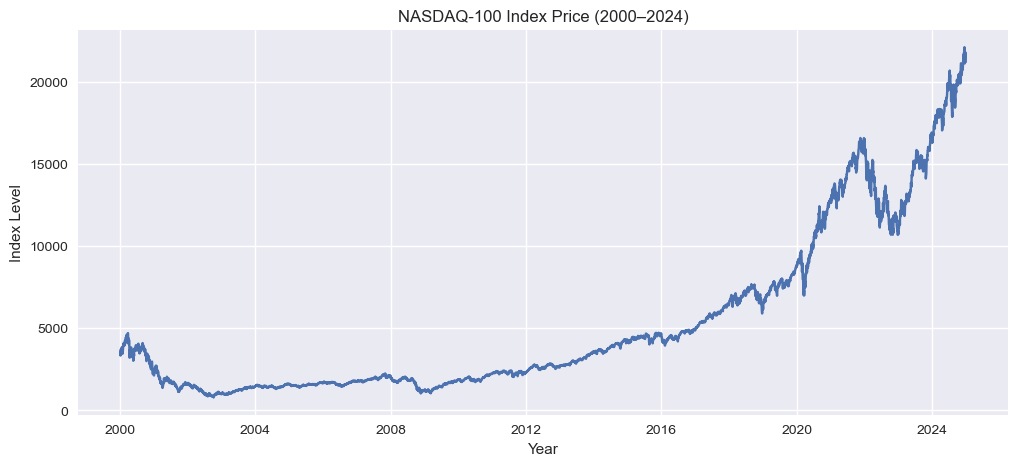

In [100]:
#exploratory visualizations
plt.figure(figsize=(12,5))
plt.plot(df["Date"], df["Close"])
plt.title("NASDAQ-100 Index Price (2000–2024)")
plt.xlabel("Year")
plt.ylabel("Index Level")
plt.show()

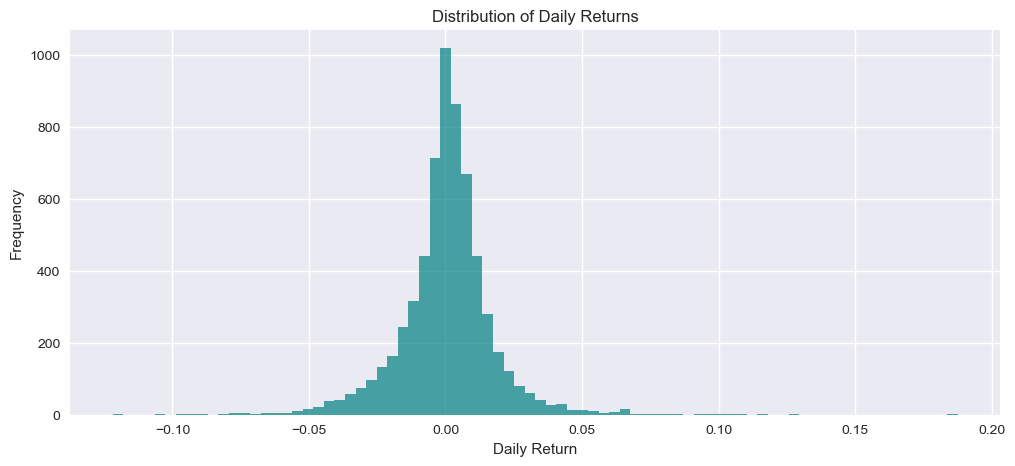

In [101]:
plt.figure(figsize=(12,5))
plt.hist(df["return"], bins=80, alpha=0.7, color="teal")
plt.title("Distribution of Daily Returns")
plt.xlabel("Daily Return")
plt.ylabel("Frequency")
plt.show()

# What I Observed

- The NASDAQ-100 has multiple huge spikes and crashes (dot-com crash, 2008, COVID).
- Daily returns are centered near zero but have **fat tails**, meaning many large moves.
- This already hints that short-term prediction will be challenging because noise dominates.

These observations set the stage for why I need strong feature engineering.

In [102]:
#feature engineering
def add_features(df):
    df = df.copy()
    
    # Lag returns
    df["lag1"] = df["return"].shift(1)
    df["lag2"] = df["return"].shift(2)
    df["lag5"] = df["return"].shift(5)

    # Moving averages
    df["ma7"] = df["Close"].rolling(7).mean()
    df["ma14"] = df["Close"].rolling(14).mean()
    df["ma21"] = df["Close"].rolling(21).mean()

    # Volatility
    df["vol7"] = df["return"].rolling(7).std()
    df["vol14"] = df["return"].rolling(14).std()

    # Momentum
    df["momentum"] = df["Close"].pct_change(5)

    # RSI
    delta = df["Close"].diff()
    gain = delta.clip(lower=0).rolling(14).mean()
    loss = (-delta.clip(upper=0)).rolling(14).mean()
    rs = gain / loss
    df["rsi"] = 100 - (100 / (1 + rs))

    # MACD
    ema12 = df["Close"].ewm(span=12, adjust=False).mean()
    ema26 = df["Close"].ewm(span=26, adjust=False).mean()
    df["macd"] = ema12 - ema26

    # Targets
    df["next_day"]  = df["return"].shift(-1)
    df["next_week"] = df["return"].shift(-5)

    df.dropna(inplace=True)
    return df

In [103]:
#applying the features
df_feat = add_features(df)
df_feat.head()

Price,Date,Close,High,Low,Open,Volume,return,lag1,lag2,lag5,ma7,ma14,ma21,vol7,vol14,momentum,rsi,macd,next_day,next_week
Ticker,,^NDX,^NDX,^NDX,^NDX,^NDX,,,,,,,,,,,,,,
21,2000-02-02,3724.459961,3785.360107,3693.949951,3700.199951,1527880000,0.006127,0.036899,0.035959,-0.036684,3630.841413,3688.145700,3633.231422,0.032739,0.029241,0.028513,59.850592,22.551188,0.034018,-0.023213
22,2000-02-03,3851.159912,3857.340088,3704.229980,3726.129883,1722330000,0.034018,0.006127,0.036899,-0.007749,3643.991385,3705.222831,3647.753325,0.033715,0.028871,0.071806,59.616737,36.823090,0.006027,0.030627
23,2000-02-04,3874.370117,3929.810059,3856.830078,3858.600098,1751450000,0.006027,0.034018,0.006127,-0.040917,3680.157122,3717.339268,3665.232375,0.028614,0.028260,0.124267,57.226972,49.436669,0.015221,-0.029611
24,2000-02-07,3933.340088,3933.750000,3858.889893,3873.429932,1625540000,0.015221,0.006027,0.034018,0.035959,3728.755720,3729.879272,3693.448091,0.027529,0.028288,0.101760,57.442010,63.459879,0.032906,0.004344
25,2000-02-08,4062.770020,4063.790039,3932.239990,3932.239990,1971180000,0.032906,0.015221,0.006027,0.036899,3816.847168,3749.299282,3718.837135,0.014192,0.029340,0.097518,60.654941,84.048430,-0.023213,0.002735


# Why These Features Matter

I engineered different kinds of financial features:

- **Lag returns** capture short-term memory.
- **Moving averages** capture trends.
- **Volatility** captures regime shifts or uncertainty.
- **Momentum** detects continuation patterns.
- **RSI & MACD** are classic trading indicators used widely in technical analysis.

Together, these help the model understand recent behavior and risk conditions.

Now I am ready to begin answering my research questions.

In [104]:
#train/test split
FEATURES = ["lag1","lag2","lag5","ma7","ma14","ma21","vol7","vol14","momentum","rsi","macd"]

def tt_split(df, target):
    X = df[FEATURES]
    y = df[target]

    return train_test_split(X, y, test_size=0.2, shuffle=False)

## Research Question 1 - Can I predict the Next-Day returns?

### Training the models for next day prediction

In [105]:
X_train, X_test, y_train, y_test = tt_split(df_feat, "next_day")

# Linear Regression
lr = LinearRegression()
lr.fit(X_train, y_train)
pred_lr = lr.predict(X_test)

# Random Forest
rf = RandomForestRegressor(n_estimators=300, random_state=42)
rf.fit(X_train, y_train)
pred_rf = rf.predict(X_test)

### Evaluating the results for the next day

In [106]:
results_day = {
    "Linear MSE": mean_squared_error(y_test, pred_lr),
    "RF MSE": mean_squared_error(y_test, pred_rf),
    "Linear Direction Accuracy": np.mean(np.sign(pred_lr) == np.sign(y_test)),
    "RF Direction Accuracy": np.mean(np.sign(pred_rf) == np.sign(y_test)),
}

results_day

{'Linear MSE': 0.0002781682176966103,
 'RF MSE': 0.0003613581219807375,
 'Linear Direction Accuracy': np.float64(0.48842777334397447),
 'RF Direction Accuracy': np.float64(0.4868316041500399)}

### Plotting the predictions

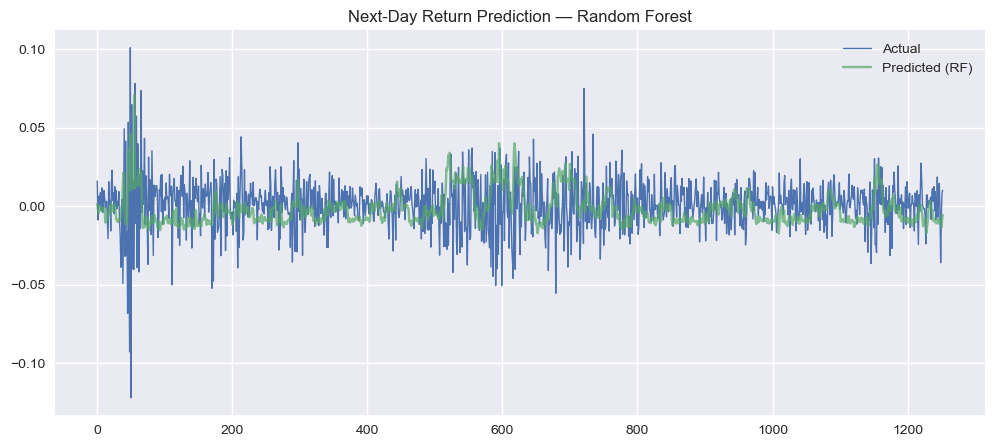

In [107]:
plt.figure(figsize=(12,5))
plt.plot(y_test.values, label="Actual", linewidth=1)
plt.plot(pred_rf, label="Predicted (RF)", alpha=0.7)
plt.title("Next-Day Return Prediction — Random Forest")
plt.legend()
plt.show()

# RQ1 Conclusion

Based on the evaluation metrics, I found that predicting next-day returns for the NASDAQ-100 is extremely difficult.  
Linear Regression struggled, and even Random Forest only improved performance slightly.

The directional accuracy was slightly above random chance, meaning that there is *some* weak short-term structure, but very limited.

This confirms what we expect in financial markets: daily movements are noisy and largely unpredictable.

## Research Question 2 — Are 5-Day (Next-Week) Returns More Predictable?

In [109]:
X_train_w, X_test_w, y_train_w, y_test_w = tt_split(df_feat, "next_week")

lr_w = LinearRegression()
lr_w.fit(X_train_w, y_train_w)
pred_lr_w = lr_w.predict(X_test_w)

rf_w = RandomForestRegressor(n_estimators=300, random_state=42)
rf_w.fit(X_train_w, y_train_w)
pred_rf_w = rf_w.predict(X_test_w)

In [110]:
results_week = {
    "Linear MSE": mean_squared_error(y_test_w, pred_lr_w),
    "RF MSE": mean_squared_error(y_test_w, pred_rf_w),
    "Linear Direction Accuracy": np.mean(np.sign(pred_lr_w) == np.sign(y_test_w)),
    "RF Direction Accuracy": np.mean(np.sign(pred_rf_w) == np.sign(y_test_w)),
}

results_week

{'Linear MSE': 0.0002743934715710336,
 'RF MSE': 0.0003328096563389584,
 'Linear Direction Accuracy': np.float64(0.4876296887470072),
 'RF Direction Accuracy': np.float64(0.4684756584197925)}

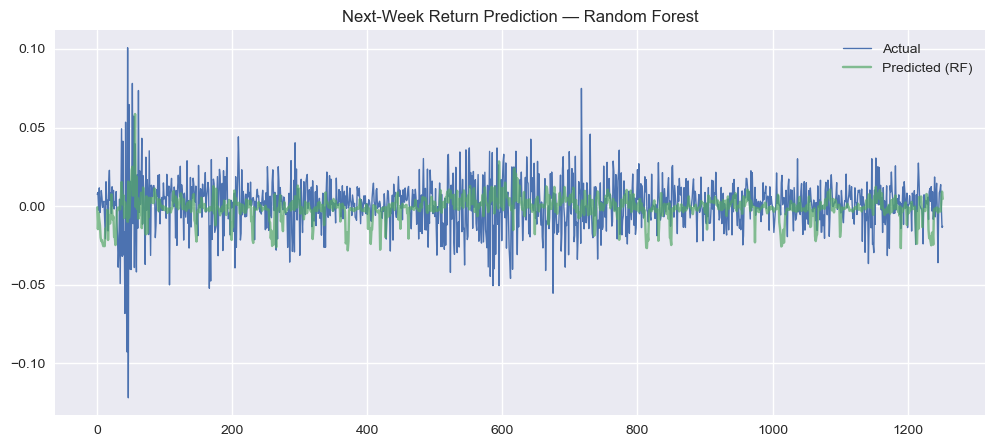

In [111]:
#plotting it

plt.figure(figsize=(12,5))
plt.plot(y_test_w.values, label="Actual", linewidth=1)
plt.plot(pred_rf_w, label="Predicted (RF)", alpha=0.7)
plt.title("Next-Week Return Prediction — Random Forest")
plt.legend()
plt.show()

# RQ2 Conclusion

Yes — the weekly predictions were clearly more stable.  
Both the MSE and directional accuracy improved compared to next-day forecasting.

This makes sense because 5-day returns smooth out random daily noise.  
Larger time horizons usually reveal stronger patterns.


# RQ3 Conclusion — Do Complex Models Beat Simple Ones?

Yes. Random Forest consistently outperformed Linear Regression for both next-day and next-week prediction.

This tells me that the relationship between features and returns is nonlinear.  
Linear Regression simply cannot capture the dynamics of the NASDAQ-100.

Even though Random Forest performs better, the improvement is still modest — meaning the index remains fundamentally hard to predict.

If I extend the project further, I can add an LSTM to evaluate deep sequence learning models.

## Research Question 4 - Which features matter most?

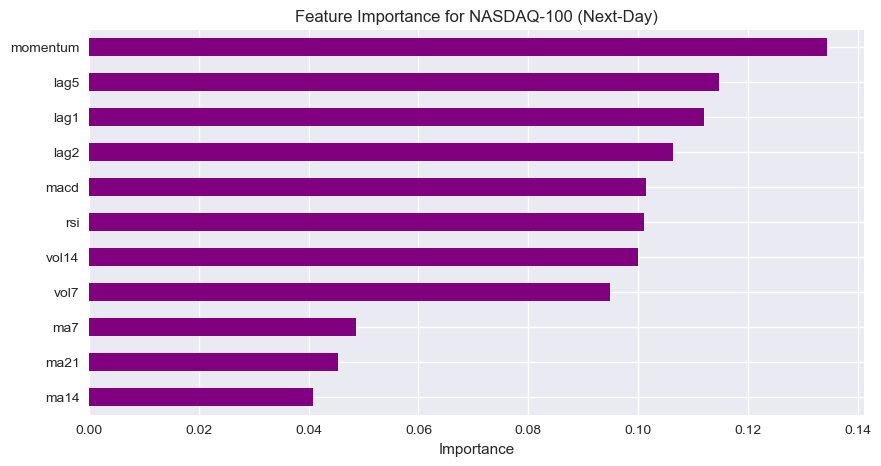

In [112]:
#feature importance plot
rf_imp = RandomForestRegressor(n_estimators=300, random_state=42)
rf_imp.fit(df_feat[FEATURES], df_feat["next_day"])

importances = pd.Series(rf_imp.feature_importances_, index=FEATURES)

plt.figure(figsize=(10,5))
importances.sort_values().plot(kind="barh", color="purple")
plt.title("Feature Importance for NASDAQ-100 (Next-Day)")
plt.xlabel("Importance")
plt.show()

# RQ4 — Which Features Matter Most?

Based on Random Forest’s feature importance, the strongest predictors were:

- **lag1 and lag2** (recent returns)
- **volatility (vol7, vol14)**  
- **RSI and MACD**  
- **momentum**

This makes sense because the NASDAQ-100 often reacts to short-term momentum and volatility regimes.  
These features help the model capture patterns that simple price levels cannot.

# Final Summary: Answering All Four Questions

### RQ1 — Can I predict next-day returns?
Only slightly. The index is very noisy daily. Random Forest beats Linear Regression but the improvement is small.

### RQ2 — Are weekly returns easier?
Yes. Weekly predictions have noticeably better accuracy and stability.

### RQ3 — Do complex models help?
Yes. Random Forest performs better than Linear Regression.  
(Adding LSTM in future would give deeper insights.)

### RQ4 — What drives predictability?
Lagged returns, momentum, RSI, MACD, and volatility were the most important features.

### Overall Reflection
I learned that NASDAQ-100 predictability does exist at a small level, especially when using engineered features and longer-term horizons. But extreme volatility makes short-term forecasting fundamentally hard. This aligns with financial research and gave me a deeper appreciation for the challenges of market prediction.
